In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sqlite3

physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
def training_data():

    dir = '../../SQL_Data/constant_setup'
    files = os.listdir(dir)
    files = [f for f in files if f.endswith('.sqlite3')]

    data = []
    for f in files:
        path = os.path.join(dir, f)
        conn = sqlite3.connect(path)
        if os.path.getsize(path) > 10000:
            cur = conn.cursor()
            cur.execute('SELECT * FROM TrainingData')
            df = pd.DataFrame(cur.fetchall())
            data.append(df)

    names = list(map(lambda x: x[0], cur.description))
    df = pd.concat(data)
    df.columns = names
    df = df.drop(['frameIdentifier','bestLapTime', 'pkt_id', 'packetId', 'SessionTime', 'finalLapTime'], axis=1)
    df.set_index('index', inplace=True)

    return df

def pad_laps(data):
    frames = []
    sessions = data.groupby('sessionUID')
    for s in list(sessions.groups):
        session = sessions.get_group(s)
        laps = session.groupby('currentLapNum')
        for l in list(laps.groups):
            lap = laps.get_group(l)
            for i in range(5):
                lap = lap.append(pd.Series(0, index=lap.columns), ignore_index=True)
            frames.append(lap)
    frames = pd.concat(frames)
    return frames

def sub_sample(df):
    arr = []
    session_groups = df.groupby('sessionUID')
    for s in list(session_groups.groups):
        session = session_groups.get_group(s)
        lap_groups = session.groupby('currentLapNum')
        for l in list(lap_groups.groups):
            lap = lap_groups.get_group(l)
            df2 = lap[lap.index % 10 == 0]  # Selects every 10th row starting from 0
            arr.append(df2)

    sub_sampled_data = pd.concat(arr)
    print(f'Full sub sample shape {sub_sampled_data.shape}')
    return sub_sampled_data


In [3]:
df1 = training_data()

df1 = sub_sample(df1)

df = df1[['lastLapTime', 'currentLapTime','fuelRemainingLaps', 'engineTemperature', 
        'fuelInTank', 'carPosition', 'lapDistance', 'worldVelocityX', 'lap_time_remaining',
       'currentLapNum', 'worldPositionX', 'tyresWearFL', 'tyresAgeLaps',
       'frontLeftWingDamage', 'tyresWearRL', 'tyresSurfaceTemperatureFR','sessionUID'
       ]]



Full sub sample shape (162867, 49)


In [4]:

data = pad_laps(df)
data.reset_index(inplace=True, drop=True)

training = pd.DataFrame()
scalers = {}
training_sessions = data.pop('sessionUID')
for i in data.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s = scaler.fit_transform(data[i].values.reshape(-1,1))
    s = np.reshape(s, len(s))
    scalers['scaler_'+ i ] = scaler
    training[i] = s
  
training['sessionUID'] = training_sessions.to_numpy()

target = training.pop('lap_time_remaining')


# training_data = []
# target_data = []
# total_laps = 0
# lap_groups = df.groupby('currentLapNum')
# total_laps += len(lap_groups)
# for l in list(lap_groups.groups):
#     lap = lap_groups.get_group(l)
#     target_data.append(lap.pop('lap_time_remaining'))
#     training_data.append(lap)
# training = [x.to_numpy() for x in training_data]
# target = [y.to_numpy() for y in target_data]
# print(f'Total Laps: {total_laps}')
# training = np.concatenate(training, axis=1)
# target = np.concatenate(target, axis=1)


# split into train and test sets
trainX, testX, trainY, testY = train_test_split(training, target, test_size=0.2, random_state=42, shuffle = False)


test_sessions = testX.pop('sessionUID')
train_session = trainX.pop('sessionUID')

test_df_names = list(testX.columns)


trainX = trainX.to_numpy()
testX = testX.to_numpy()
trainY = trainY.to_numpy()
testY = testY.to_numpy()




# create overlapping windows
timesteps = training.shape[0]-1
look_back = 10
batch_size = 2
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(trainX, trainY, length=look_back, sampling_rate=1, stride=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(testX, testY, length=look_back, sampling_rate=1, stride=1, batch_size=1)


train_X, train_y = train_generator[0]
test_X, test_y = test_generator[0]

train_samples = train_X.shape[0]*len(train_generator)
test_samples = test_X.shape[0]*len(test_generator)

print("Total Records: {}".format(len(training)))
print("Number of samples in training set (.8 * n): trainX = {}".format(trainX.shape[0]))
print("Number of samples in testing set (.2 * n): testX = {}".format(testX.shape[0]))
print("Number of total samples in training feature set: {}".format(train_samples))
print("Number of samples in testing feature set: {}".format(test_samples))

Total Records: 163987
Number of samples in training set (.8 * n): trainX = 131189
Number of samples in testing set (.2 * n): testX = 32798
Number of total samples in training feature set: 131180
Number of samples in testing feature set: 32788


In [5]:
# define model
learning_rate = 0.001
units = 128
epochs = 15
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units, return_sequences=True)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(1))

adam = tf.keras.optimizers.Adam(lr=0.001)
callback = [EarlyStopping(min_delta = 0.0001, patience = 3, mode = 'auto', restore_best_weights=True),  ModelCheckpoint('generator_sel_lstm.h5')] 
model.compile(optimizer=adam, loss='mse', metrics=['mae'])

# model = tf.keras.models.load_model('generator_lstm.h5')
history = model.fit(train_generator, validation_data = test_generator, callbacks=callback, shuffle=False, epochs=epochs) 

Epoch 1/15
65590/65590 [==============================] - 719s 11ms/step - loss: 0.0364 - mae: 0.0929 - val_loss: 0.0028 - val_mae: 0.0409
Epoch 2/15
65590/65590 [==============================] - 697s 11ms/step - loss: 0.0027 - mae: 0.0376 - val_loss: 0.0030 - val_mae: 0.0425
Epoch 3/15
65590/65590 [==============================] - 712s 11ms/step - loss: 0.0025 - mae: 0.0337 - val_loss: 0.0031 - val_mae: 0.0430
Epoch 4/15
65590/65590 [==============================] - 703s 11ms/step - loss: 0.0023 - mae: 0.0315 - val_loss: 0.0054 - val_mae: 0.0605


In [6]:
model = tf.keras.models.load_model('generator_final_lstm.h5')
pred = model.predict(test_generator)

In [7]:
predictions = scalers['scaler_lap_time_remaining'].inverse_transform(pred)
truth = [y for (x,y) in test_generator]
# for i in range(len(test_generator)):
#     x,y = test_generator[i]
#     truth.append(y)
    
truth = np.array(truth)
truth = scalers['scaler_lap_time_remaining'].inverse_transform(truth)
err = truth-predictions

In [8]:
# test_df = pd.DataFrame()
# df
# for col in list(df.columns):
#     unscaled = scalers[f'scaler_{col}'].inverse_transform(df[col].values.reshape(-1,1))
#     unscaled = np.reshape(unscaled, len(unscaled))
#     test_df[col] = unscaled

ans = pd.DataFrame()
ans['truth'] = truth.ravel()
ans['predictions'] = predictions.ravel()
ans['residuals'] = err.ravel()

In [9]:
# ans.to_csv('gen_lstm_dimitrios.csv')

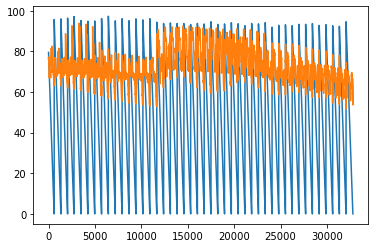

In [10]:
from matplotlib import pyplot as plt
plt.plot(ans['truth'])
plt.plot(ans['predictions'])
plt.show()

In [11]:
test_df = pd.DataFrame(testX)
names = list(data.columns)
names = names[:-1]
test_df.columns = names

for col in list(test_df.columns):
    us = scalers[f'scaler_{col}'].inverse_transform(test_df[col].values.reshape(-1,1))
    us = np.reshape(us, len(us))
    test_df[col] = us

test_df['sessionUID'] = test_sessions.to_numpy()
test_df['truth'] = pd.Series(ans['truth'])
test_df['predictions'] = pd.Series(ans['predictions'])
test_df['residuals'] = pd.Series(ans['residuals'])
test_df.to_csv('LSTM_sel.csv')

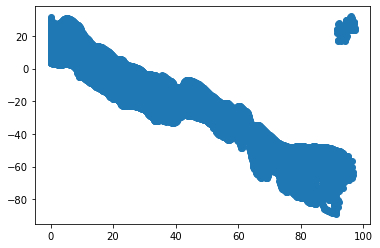

In [12]:
plt.scatter(x = test_df['currentLapTime'], y = test_df['residuals'])
plt.show()

In [13]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32798 entries, 0 to 32797
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lastLapTime          32798 non-null  float64
 1   currentLapTime       32798 non-null  float64
 2   fuelRemainingLaps    32798 non-null  float64
 3   engineTemperature    32798 non-null  float64
 4   fuelInTank           32798 non-null  float64
 5   carPosition          32798 non-null  float64
 6   lapDistance          32798 non-null  float64
 7   worldVelocityX       32798 non-null  float64
 8   lap_time_remaining   32798 non-null  float64
 9   currentLapNum        32798 non-null  float64
 10  worldPositionX       32798 non-null  float64
 11  tyresWearFL          32798 non-null  float64
 12  tyresAgeLaps         32798 non-null  float64
 13  frontLeftWingDamage  32798 non-null  float64
 14  tyresWearRL          32798 non-null  float64
 15  sessionUID           32798 non-null 

In [14]:
def var_importance(model, g):
    x = np.concatenate([next(g)[0] for _ in range(50)]) # Get a sample of data
    orig_out = model.predict(x)
    for i in range():  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
        
var_importance(model, test_generator)
        
    

TypeError: 'TimeseriesGenerator' object is not an iterator